# Regularizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 128481888.44it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35554943.89it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56822237.90it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7318681.82it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [5]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## Build Regularized Model & Optimizer

In [6]:
class Block(nn.Module):

    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)

        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)

        return y

In [7]:
class MyModel(nn.Module):

    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):

        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            nn.Linear(100, output_size),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.layers(x)
        # |y| = (batch_size, output_size)

        return y

In [8]:
model = MyModel(input_size,
                output_size,
                use_batch_norm=True)

model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [9]:
crit = nn.NLLLoss()

In [10]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [12]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

## Train

In [13]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [14]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [15]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()

    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)

    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=1.9133e-02  valid_loss=8.0217e-02  lowest_loss=7.1169e-02
Epoch 20: train loss=1.4379e-02  valid_loss=9.9141e-02  lowest_loss=7.1169e-02
Epoch 30: train loss=8.7611e-03  valid_loss=7.8941e-02  lowest_loss=7.1071e-02
Epoch 40: train loss=2.9915e-03  valid_loss=7.8906e-02  lowest_loss=7.1071e-02
Epoch 50: train loss=4.7954e-03  valid_loss=8.2001e-02  lowest_loss=7.1071e-02
Epoch 60: train loss=5.0682e-03  valid_loss=8.3814e-02  lowest_loss=7.1071e-02
Epoch 70: train loss=3.5295e-03  valid_loss=8.5885e-02  lowest_loss=7.0595e-02
Epoch 80: train loss=2.9959e-03  valid_loss=8.3524e-02  lowest_loss=7.0595e-02
Epoch 90: train loss=2.8838e-03  valid_loss=8.7955e-02  lowest_loss=7.0595e-02
Epoch 100: train loss=2.9238e-03  valid_loss=8.4161e-02  lowest_loss=7.0595e-02
Epoch 110: train loss=2.2635e-03  valid_loss=9.2981e-02  lowest_loss=7.0595e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 61: 7.0595e-02


<All keys matched successfully>

## Loss History

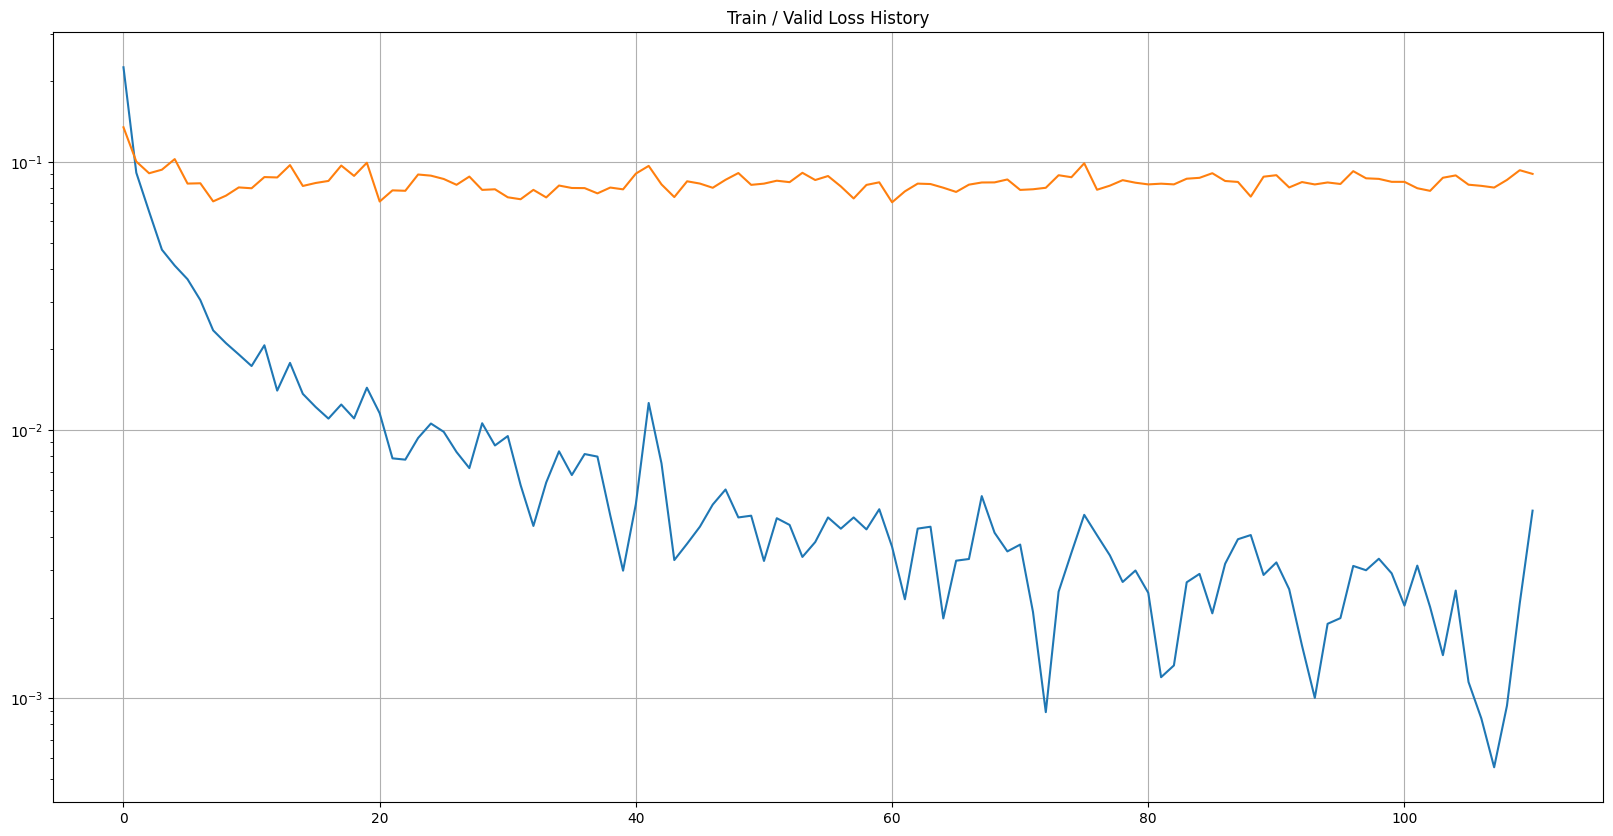

In [16]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [17]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 7.7799e-02


In [18]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9831


In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [21]:
pd.DataFrame(confusion_matrix(y[-1].cpu(), torch.argmax(y_hat.cpu(), dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,974,1,0,1,0,0,1,1,2,0
true_1,1,1123,1,1,0,1,2,3,3,0
true_2,4,0,1018,0,1,0,3,4,1,1
true_3,0,1,5,988,0,9,0,4,2,1
true_4,1,0,1,0,959,0,7,1,2,11
true_5,2,1,1,7,0,873,4,1,1,2
true_6,3,2,0,0,1,1,949,1,1,0
true_7,2,3,6,1,2,0,0,1007,1,6
true_8,1,0,3,3,0,1,1,3,957,5
true_9,0,2,0,5,7,5,0,5,2,983
